# DiscoGAN
This is an attempt to implement discoGAN using Keras

## Loading Dependencies

In [141]:
%matplotlib inline
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import cv2

from glob import glob
from tqdm import *

import keras
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape, LeakyReLU, Input
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, ZeroPadding2D, GlobalAveragePooling2D
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop

from sklearn.utils import shuffle
%autosave 120

Autosaving every 120 seconds


## Loading the dataset

In [2]:
#get the paths for the training and validation images
train_data_paths = glob("data/cityscapes/train/*.jpg")
val_data_paths = glob("data/cityscapes/val/*.jpg")
#print the number of images in every dataset
print(len(train_data_paths))
print(len(val_data_paths))

2975
500


(256, 512, 3)
(256, 256, 3)
(256, 256, 3)


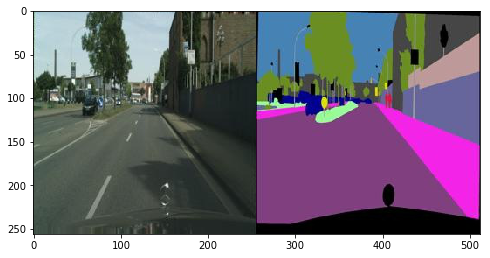

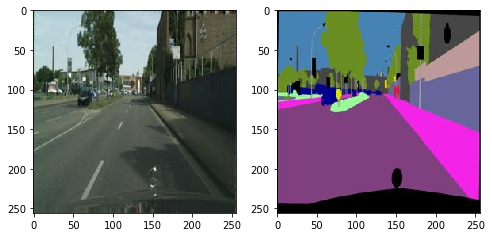

In [3]:
#visualising the data
#get a random image
indxs = np.random.randint(0, high=len(train_data_paths), size=1)
img = cv2.imread(train_data_paths[indxs[0]])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#print image shape
shape = img.shape
print(shape)
#visualise the image
f, (ax1) = plt.subplots(1, figsize=(8,8))
ax1.imshow(img)
#split the image into image A and image B
A = img[:,:shape[1]//2,:]
B = img[:,(shape[1]//2):,:]
#print each image's shape
A_image_shape = A.shape
B_image_shape = B.shape
print(A_image_shape)
print(B_image_shape)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
ax1.imshow(A)
ax2.imshow(B)
plt.show()

In [47]:
#making the A and B datasets

#making tensors to hold the data
A_data = np.zeros((len(train_data_paths), *A_image_shape))
B_data = np.zeros((len(train_data_paths), *B_image_shape))

#looping over the training images and saving them 
for i in tqdm(range(0,len(train_data_paths))):
    img = cv2.imread(train_data_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    shape = img.shape
    A = img[:,:(shape[1]//2),:]
    B = img[:,(shape[1]//2):,:]
    A_data[i,:,:,:] = A
    B_data[i,:,:,:] = B
print(B.max())
print(A.max())

 37%|███▋      | 1111/2975 [00:17<00:30, 61.83it/s]

KeyboardInterrupt: 

## Models

In [113]:
G_AB = Sequential()
#encoder
G_AB.add(ZeroPadding2D(padding=0, input_shape=(256, 256, 3)))
G_AB.add(Conv2D(filters=64, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_AB.add(LeakyReLU(alpha=0.2))

# G_AB.add(ZeroPadding2D(padding=1))
G_AB.add(Conv2D(filters=64*2, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_AB.add(BatchNormalization(momentum=0.1))
G_AB.add(LeakyReLU(alpha=0.2))

# G_AB.add(ZeroPadding2D(padding=1))
G_AB.add(Conv2D(filters=64*4, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_AB.add(BatchNormalization(momentum=0.1))
G_AB.add(LeakyReLU(alpha=0.2))

# G_AB.add(ZeroPadding2D(padding=1))
G_AB.add(Conv2D(filters=64*8, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_AB.add(BatchNormalization(momentum=0.1))
G_AB.add(LeakyReLU(alpha=0.2))


#decoder

# G_AB.add(ZeroPadding2D(padding=1))
G_AB.add(Conv2DTranspose(filters=64*4, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_AB.add(BatchNormalization(momentum=0.1))
G_AB.add(Activation('relu'))

# G_AB.add(ZeroPadding2D(padding=1))
G_AB.add(Conv2DTranspose(filters=64*2, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_AB.add(BatchNormalization(momentum=0.1))
G_AB.add(Activation('relu'))

# G_AB.add(ZeroPadding2D(padding=1))
G_AB.add(Conv2DTranspose(filters=64*1, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_AB.add(BatchNormalization(momentum=0.1))
G_AB.add(Activation('relu'))

G_AB.add(ZeroPadding2D(padding=1))
G_AB.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding='same', use_bias=False ))
G_AB.add(Activation('sigmoid'))


G_AB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_714 (ZeroPadd (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_465 (Conv2D)          (None, 127, 127, 64)      3072      
_________________________________________________________________
leaky_re_lu_461 (LeakyReLU)  (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_466 (Conv2D)          (None, 62, 62, 128)       131072    
_________________________________________________________________
batch_normalization_657 (Bat (None, 62, 62, 128)       512       
_________________________________________________________________
leaky_re_lu_462 (LeakyReLU)  (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_467 (Conv2D)          (None, 30, 30, 256)       524288    
__________

In [114]:
G_BA = Sequential()
#encoder
G_BA.add(ZeroPadding2D(padding=0, input_shape=(256, 256, 3)))
G_BA.add(Conv2D(filters=64, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_BA.add(LeakyReLU(alpha=0.2))

# G_BA.add(ZeroPadding2D(padding=1))
G_BA.add(Conv2D(filters=64*2, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_BA.add(BatchNormalization(momentum=0.1))
G_BA.add(LeakyReLU(alpha=0.2))

# G_BA.add(ZeroPadding2D(padding=1))
G_BA.add(Conv2D(filters=64*4, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_BA.add(BatchNormalization(momentum=0.1))
G_BA.add(LeakyReLU(alpha=0.2))

# G_BA.add(ZeroPadding2D(padding=1))
G_BA.add(Conv2D(filters=64*8, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_BA.add(BatchNormalization(momentum=0.1))
G_BA.add(LeakyReLU(alpha=0.2))


#decoder

# G_BA.add(ZeroPadding2D(padding=1))
G_BA.add(Conv2DTranspose(filters=64*4, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_BA.add(BatchNormalization(momentum=0.1))
G_BA.add(Activation('relu'))

# G_BA.add(ZeroPadding2D(padding=1))
G_BA.add(Conv2DTranspose(filters=64*2, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_BA.add(BatchNormalization(momentum=0.1))
G_BA.add(Activation('relu'))

# G_BA.add(ZeroPadding2D(padding=1))
G_BA.add(Conv2DTranspose(filters=64*1, kernel_size=4, strides=2, padding='valid', use_bias=False ))
G_BA.add(BatchNormalization(momentum=0.1))
G_BA.add(Activation('relu'))

G_BA.add(ZeroPadding2D(padding=1))
G_BA.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding='same', use_bias=False ))
G_BA.add(Activation('sigmoid'))


G_BA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_716 (ZeroPadd (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_469 (Conv2D)          (None, 127, 127, 64)      3072      
_________________________________________________________________
leaky_re_lu_465 (LeakyReLU)  (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_470 (Conv2D)          (None, 62, 62, 128)       131072    
_________________________________________________________________
batch_normalization_663 (Bat (None, 62, 62, 128)       512       
_________________________________________________________________
leaky_re_lu_466 (LeakyReLU)  (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_471 (Conv2D)          (None, 30, 30, 256)       524288    
__________

In [146]:
D_A = Sequential()

D_A.add(ZeroPadding2D(padding=0, input_shape=(256, 256, 3)))
D_A.add(Conv2D(filters=64, kernel_size=4, strides=2, padding='valid', use_bias=False ))
D_A.add(LeakyReLU(alpha=0.2))

# D_A.add(ZeroPadding2D(padding=1))
D_A.add(Conv2D(filters=64*2, kernel_size=4, strides=2, padding='valid', use_bias=False ))
D_A.add(BatchNormalization(momentum=0.1))
D_A.add(LeakyReLU(alpha=0.2))

# D_A.add(ZeroPadding2D(padding=1))
D_A.add(Conv2D(filters=64*4, kernel_size=4, strides=2, padding='valid', use_bias=False ))
D_A.add(BatchNormalization(momentum=0.1))
D_A.add(LeakyReLU(alpha=0.2))

# D_A.add(ZeroPadding2D(padding=1))
D_A.add(Conv2D(filters=64*8, kernel_size=4, strides=2, padding='valid', use_bias=False ))
D_A.add(BatchNormalization(momentum=0.1))
D_A.add(LeakyReLU(alpha=0.2))

# D_A.add(ZeroPadding2D(padding=1))
D_A.add(Conv2D(filters=1, kernel_size=4, strides=2, padding='valid', use_bias=False ))
D_A.add(GlobalAveragePooling2D())
D_A.add(Activation('sigmoid'))

D_A.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_751 (ZeroPadd (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_622 (Conv2D)          (None, 127, 127, 64)      3072      
_________________________________________________________________
leaky_re_lu_590 (LeakyReLU)  (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_623 (Conv2D)          (None, 62, 62, 128)       131072    
_________________________________________________________________
batch_normalization_760 (Bat (None, 62, 62, 128)       512       
_________________________________________________________________
leaky_re_lu_591 (LeakyReLU)  (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_624 (Conv2D)          (None, 30, 30, 256)       524288    
__________

In [147]:
D_B = Sequential()

D_B.add(ZeroPadding2D(padding=0, input_shape=(256, 256, 3)))
D_B.add(Conv2D(filters=64, kernel_size=4, strides=2, padding='valid', use_bias=False ))
D_B.add(LeakyReLU(alpha=0.2))

# D_B.add(ZeroPadding2D(padding=1))
D_B.add(Conv2D(filters=64*2, kernel_size=4, strides=2, padding='valid', use_bias=False ))
D_B.add(BatchNormalization(momentum=0.1))
D_B.add(LeakyReLU(alpha=0.2))

# D_B.add(ZeroPadding2D(padding=1))
D_B.add(Conv2D(filters=64*4, kernel_size=4, strides=2, padding='valid', use_bias=False ))
D_B.add(BatchNormalization(momentum=0.1))
D_B.add(LeakyReLU(alpha=0.2))

# D_B.add(ZeroPadding2D(padding=1))
D_B.add(Conv2D(filters=64*8, kernel_size=4, strides=2, padding='valid', use_bias=False ))
D_B.add(BatchNormalization(momentum=0.1))
D_B.add(LeakyReLU(alpha=0.2))

# D_B.add(ZeroPadding2D(padding=1))
D_B.add(Conv2D(filters=1, kernel_size=4, strides=2, padding='valid', use_bias=False ))
D_B.add(GlobalAveragePooling2D())
D_B.add(Activation('sigmoid'))

D_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_752 (ZeroPadd (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_627 (Conv2D)          (None, 127, 127, 64)      3072      
_________________________________________________________________
leaky_re_lu_594 (LeakyReLU)  (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_628 (Conv2D)          (None, 62, 62, 128)       131072    
_________________________________________________________________
batch_normalization_763 (Bat (None, 62, 62, 128)       512       
_________________________________________________________________
leaky_re_lu_595 (LeakyReLU)  (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_629 (Conv2D)          (None, 30, 30, 256)       524288    
__________